<a href="https://colab.research.google.com/github/gyeonghun3388-netizen/RL-PJT-2025.2H/blob/main/%EA%B0%95%ED%99%94%ED%95%99%EC%8A%B5%EA%B8%B0%EB%A7%90%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random
from collections import deque
from typing import Tuple, Dict, Any

import numpy as np
import pandas as pd
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim


# =========================
# 1. 데이터 로딩 유틸
# =========================

def load_ai4i_dataset(csv_path: str) -> pd.DataFrame:
    """
    AI4I 2020 Predictive Maintenance Dataset 로딩 함수.
    - 경로에 ai4i2020.csv 가 있다고 가정.
    - 본 예제에서는 통계 확인/확장용으로만 사용하고, Env는 자체 규칙 기반으로 샘플링 가능.
    """
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"CSV file not found: {csv_path}")
    df = pd.read_csv(csv_path)
    return df


# =========================
# 2. 환경 정의 (Gym Env)
# =========================

class Ai4iMaintenanceEnv(gym.Env):
    """
    AI4I 2020 데이터 설명서의 failure 규칙을 기반으로 한
    가상 제조 설비 유지보수 환경.

    상태(state):
        [air_temp, process_temp, speed, torque, tool_wear,
         type_L, type_M, type_H, time_since_maint]

    행동(action):
        0: 계속 운전 (do nothing)
        1: 예방 정비 (preventive maintenance)
    """
    metadata = {"render_modes": []}

    def __init__(
        self,
        pm_cost: float = 5.0,
        fail_cost: float = 50.0,
        prod_reward: float = 1.0,
        max_steps: int = 200,
        random_seed: int = 0,
    ):
        # 부모 클래스인 gym.Env의 생성자를 호출하여 환경의 기본 설정을 초기화합니다.
        # 이는 상속받은 클래스가 부모 클래스의 모든 필수 초기화 단계를 수행하도록 보장합니다.
        super().__init__()
        self.pm_cost = pm_cost
        self.fail_cost = fail_cost
        self.prod_reward = prod_reward
        self.max_steps = max_steps
        self.rng = np.random.RandomState(random_seed)

        # 관측 공간 / 행동 공간 정의
        self.obs_dim = 9  # 위 주석의 state 구성 참고
        self.action_space = spaces.Discrete(2)  # 0: continue, 1: PM
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.obs_dim,), dtype=np.float32
        )

        self.reset()

    # ---------- 내부 유틸 함수들 ----------

    def _sample_type(self) -> None:
        """
        제품 Type(L/M/H) 샘플링.
        예시로 L:50%, M:30%, H:20% 비율 사용.
        """
        r = self.rng.rand()
        if r < 0.5:
            self.type = "L"
        elif r < 0.8:
            self.type = "M"
        else:
            self.type = "H"

    def _sample_process_conditions(self) -> None:
        """
        공정 조건을 랜덤 샘플링.
        - Air temp ~ N(300, 2^2)
        - Process temp ~ Air + 10 + N(0, 1^2)
        - Rotational speed ~ N(1500, 200^2)
        - Torque ~ max(0, N(40, 10^2))
        """
        air_temp = 300 + self.rng.randn() * 2  # K
        process_temp = air_temp + 10 + self.rng.randn() * 1
        speed = self.rng.normal(1500, 200)  # rpm
        torque = max(0.0, self.rng.normal(40, 10))  # Nm (음수 방지)

        self.air_temp = air_temp
        self.process_temp = process_temp
        self.speed = speed
        self.torque = torque

    def _get_wear_increment(self) -> float:
        """
        Type에 따라 wear 증가량을 다르게 설정.
        AI4I 데이터의 설명에 맞춰 L/M/H에 따라 2/3/5 분 증가.
        """
        if self.type == "L":
            return 2.0
        elif self.type == "M":
            return 3.0
        else:
            return 5.0

    def _check_failure(self) -> Tuple[bool, Dict[str, bool]]:
        """
        AI4I 설명서 기반 failure mode 계산:
        - TWF, HDF, PWF, OSF, RNF
        """
        # TWF (Tool Wear Failure)
        # wear 가 200~240 사이일 때 일정 확률로 failure 발생
        twf = False
        if 200.0 <= self.tool_wear <= 240.0:
            # 예시로 50% 확률
            twf = self.rng.rand() < 0.5

        # HDF (Heat Dissipation Failure)
        delta_T = self.process_temp - self.air_temp
        hdf = (delta_T < 8.6) and (self.speed < 1380.0)

        # PWF (Power Failure)
        omega = self.speed * 2 * np.pi / 60.0  # rad/s
        power = self.torque * omega  # W
        pwf = (power < 3500.0) or (power > 9000.0)

        # OSF (Overstrain Failure)
        if self.type == "L":
            threshold = 11000.0
        elif self.type == "M":
            threshold = 12000.0
        else:
            threshold = 13000.0
        osf = (self.tool_wear * self.torque) > threshold

        # RNF (Random Failure)
        rnf = self.rng.rand() < 0.001  # 0.1%

        failure = twf or hdf or pwf or osf or rnf
        return failure, {"twf": twf, "hdf": hdf, "pwf": pwf, "osf": osf, "rnf": rnf}

    def _get_obs(self) -> np.ndarray:
        """
        Min-Max Normalization 적용
        신경망 학습 안정을 위해 모든 값을 대략 0~1 사이로 변환합니다.
        """
        type_one_hot = {
            "L": [1.0, 0.0, 0.0],
            "M": [0.0, 1.0, 0.0],
            "H": [0.0, 0.0, 1.0],
        }[self.type]

      # 정규화 (데이터셋 통계 기반 근사치 사용)
        # Air Temp: 295~305K
        norm_air = (self.air_temp - 295.0) / (305.0 - 295.0)
        # Process Temp: 305~315K
        norm_proc = (self.process_temp - 305.0) / (315.0 - 305.0)
        # Speed: 1168~2886 rpm -> 대략 1100~2900으로 설정
        norm_speed = (self.speed - 1100.0) / (2900.0 - 1100.0)
        # Torque: 3.8~76.6 Nm -> 대략 0~80으로 설정
        norm_torque = self.torque / 80.0
        # Tool Wear: 0~253 -> 대략 0~260으로 설정
        norm_wear = self.tool_wear / 260.0
        # Time since maint: 대략 0~260 (Tool wear와 유사하게 증가하므로)
        norm_time = self.time_since_maint / 260.0

        obs = np.array(
            [
                norm_air,
                norm_proc,
                norm_speed,
                norm_torque,
                norm_wear,
                *type_one_hot,
                norm_time,
            ],
            dtype=np.float32,
        )
        return obs

    # ---------- Gym 필수 메서드들 ----------

    def reset(self) -> np.ndarray:
        """
        에피소드 시작 시 상태 초기화.
        """
        self.t = 0
        self.tool_wear = 0.0
        self.time_since_maint = 0

        self._sample_type()
        self._sample_process_conditions()

        return self._get_obs()

    def step(self, action: int) -> Tuple[np.ndarray, float, bool, Dict[str, Any]]:
        """
        한 step 진행.

        action:
            0: continue
            1: preventive maintenance
        """
        assert self.action_space.contains(action)

        done = False
        info: Dict[str, Any] = {}

        # 1) maintenance action 처리
        if action == 1:  # PM
            reward = -self.pm_cost
            self.tool_wear = 0.0
            self.time_since_maint = 0
        else:  # continue
            reward = self.prod_reward
            self.tool_wear += self._get_wear_increment()
            self.time_since_maint += 1

        # 2) failure check
        failure, failure_modes = self._check_failure()
        info.update(failure_modes)

        if failure:
            reward -= self.fail_cost
            done = True
            info["failure"] = True
        else:
            info["failure"] = False

        # 3) step 카운트 및 종료 조건
        self.t += 1
        if self.t >= self.max_steps:
            done = True

        # 4) 다음 step 공정 조건 샘플링
        self._sample_type()
        self._sample_process_conditions()

        obs = self._get_obs()
        return obs, float(reward), done, info

    def render(self, mode="human"):
        """
        필요시 상태 출력용 (현재는 간단히 print만).
        """
        print(
            f"t={self.t}, wear={self.tool_wear:.1f}, type={self.type}, "
            f"T_air={self.air_temp:.1f}, T_proc={self.process_temp:.1f}, "
            f"speed={self.speed:.1f}, torque={self.torque:.1f}"
        )


# =========================
# 3. Replay Buffer
# =========================

# ReplayBuffer 클래스는 DQN 학습의 핵심 요소 중 하나인 '경험 리플레이'를 구현합니다.
# 에이전트가 환경과 상호작용하며 얻은 경험(상태, 행동, 보상, 다음 상태, 종료 여부)을 저장하고,
# 나중에 이 경험들을 무작위로 샘플링하여 Q-네트워크를 업데이트하는 데 사용됩니다.
# 이는 학습 데이터의 상관관계를 줄이고 학습의 안정성을 높이는 데 도움을 줍니다.
class ReplayBuffer:
    # 생성자: 리플레이 버퍼의 최대 용량을 설정합니다.
    # deque(double-ended queue)를 사용하여 효율적인 추가/삭제를 가능하게 합니다.
    def __init__(self, capacity: int = 100_000):
        self.buffer = deque(maxlen=capacity)

    # 버퍼에 저장된 경험의 개수를 반환합니다.
    def __len__(self) -> int:
        return len(self.buffer)

    # 새로운 경험(state, action, reward, next_state, done)을 버퍼에 추가합니다.
    # 버퍼가 최대 용량에 도달하면 가장 오래된 경험이 자동으로 제거됩니다.
    def push(self, state, action, reward, next_state, done):
        self.buffer.append(
            (
                np.array(state, copy=False),  # 현재 상태 (넘파이 배열로 저장)
                int(action),                  # 에이전트가 선택한 행동 (정수형)
                float(reward),                # 행동 후 받은 보상 (실수형)
                np.array(next_state, copy=False), # 다음 상태 (넘파이 배열로 저장)
                bool(done),                   # 에피소드 종료 여부 (부울형)
            )
        )

    # 버퍼에서 지정된 배치 크기(batch_size)만큼의 경험을 무작위로 샘플링하여 반환합니다.
    # 샘플링된 경험들은 Q-네트워크 업데이트에 사용될 수 있도록 각각의 리스트로 분리됩니다.
    def sample(self, batch_size: int):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(
            np.array, zip(*batch)
        )
        return states, actions, rewards, next_states, dones


# =========================
# 4. DQN 네트워크 & 에이전트
# =========================

class QNetwork(nn.Module):
    def __init__(self, state_dim: int, action_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


class DQNAgent:
    def __init__(
        self,
        state_dim: int,
        action_dim: int,
        lr: float = 1e-3,
        gamma: float = 0.99,
        buffer_capacity: int = 100_000,
        eps_start: float = 1.0,
        eps_end: float = 0.05,
        eps_decay_steps: int = 50_000,
        device: str = None,
    ):
        super().__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma

        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")

        self.q_net = QNetwork(state_dim, action_dim).to(self.device)
        self.target_net = QNetwork(state_dim, action_dim).to(self.device)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)

        self.buffer = ReplayBuffer(capacity=buffer_capacity)

        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_decay_steps = eps_decay_steps
        self.total_steps = 0

    def _get_epsilon(self) -> float:
        ratio = min(1.0, self.total_steps / self.eps_decay_steps)
        eps = self.eps_start + ratio * (self.eps_end - self.eps_start)
        return float(eps)

    def select_action(self, state: np.ndarray) -> int:
        """
        ε-greedy 정책으로 action 선택.
        """
        eps = self._get_epsilon()
        self.total_steps += 1

        if random.random() < eps:
            return random.randrange(self.action_dim)
        else:
            with torch.no_grad():
                s = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
                q_values = self.q_net(s)
                return int(q_values.argmax(dim=1).item())

    def update(self, batch_size: int = 64):
        """
        Replay buffer에서 미니배치를 샘플링해 Q-network 업데이트.
        """
        if len(self.buffer) < batch_size:
            return None

        states, actions, rewards, next_states, dones = self.buffer.sample(batch_size)

        states = torch.tensor(states, dtype=torch.float32, device=self.device)
        actions = torch.tensor(actions, dtype=torch.long, device=self.device).unsqueeze(-1)
        rewards = torch.tensor(rewards, dtype=torch.float32, device=self.device).unsqueeze(-1)
        next_states = torch.tensor(next_states, dtype=torch.float32, device=self.device)
        dones = torch.tensor(dones, dtype=torch.float32, device=self.device).unsqueeze(-1)

        # 현재 Q(s,a)
        q_values = self.q_net(states).gather(1, actions)

        # target = r + γ Q_target(s', argmax_a' Q_net(s', a'))  # Double DQN
        with torch.no_grad():
            # Step 1: Select the optimal next action using the current Q-network
            next_actions = self.q_net(next_states).argmax(dim=1, keepdim=True)
            # Step 2: Evaluate the Q-value of the selected next action using the target network
            next_q_values = self.target_net(next_states).gather(1, next_actions)
            targets = rewards + self.gamma * (1.0 - dones) * next_q_values

        loss = nn.functional.mse_loss(q_values, targets)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return float(loss.item())

    def update_target(self):
        self.target_net.load_state_dict(self.q_net.state_dict())

class HeuristicAgent:
    def __init__(self, threshold=200):
        self.threshold = threshold

    def select_action(self, state, raw_wear_index=4): # index 4가 tool_wear라고 가정
        # 정규화 전의 tool_wear 값을 알 수 있다면 베스트지만,
        # 정규화된 상태라면 threshold도 정규화해서 비교
        current_wear = state[raw_wear_index]

        # 예: Tool wear가 특정 수치를 넘으면 무조건 정비
        if current_wear > self.threshold:
            return 1 #(Maintenance)
        return 0 #(Continue)

# =========================
# 5. 학습 루프 (train_dqn)
# =========================

def train_dqn(
    num_episodes: int = 500,
    max_steps_per_episode: int = 200,
    target_update_interval: int = 1000,
    batch_size: int = 64,
    render: bool = False,
):
    env = Ai4iMaintenanceEnv(max_steps=max_steps_per_episode)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    agent = DQNAgent(state_dim, action_dim)

    total_steps = 0
    episode_returns = []

    for episode in range(1, num_episodes + 1):
        state = env.reset()
        done = False
        ep_return = 0.0

        while not done:
            if render and (episode % 100 == 0):
                env.render()

            action = agent.select_action(state)
            next_state, reward, done, info = env.step(action)

            agent.buffer.push(state, action, reward, next_state, done)
            loss = agent.update(batch_size=batch_size)

            state = next_state
            ep_return += reward
            total_steps += 1

            if total_steps % target_update_interval == 0:
                agent.update_target()

        episode_returns.append(ep_return)
        avg_return = np.mean(episode_returns[-20:])

        print(
            f"[Episode {episode:4d}] "
            f"Return = {ep_return:8.2f} | "
            f"Avg(20) = {avg_return:8.2f} | "
            f"Buffer = {len(agent.buffer):6d}"
        )

    # 학습 후 모델 저장
    os.makedirs("checkpoints", exist_ok=True)
    model_path = os.path.join("checkpoints", "dqn_ai4i.pt")
    torch.save(agent.q_net.state_dict(), model_path)
    print(f"Model saved to: {model_path}")

    return agent, episode_returns


if __name__ == "__main__":
    # 예시 실행
    agent, returns = train_dqn(
        num_episodes=300,
        max_steps_per_episode=200,
        target_update_interval=1000,
        batch_size=64,
        render=False,
    )

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[Episode    1] Return =   -57.00 | Avg(20) =   -57.00 | Buffer =      5
[Episode    2] Return =   -59.00 | Avg(20) =   -58.00 | Buffer =      8
[Episode    3] Return =   -75.00 | Avg(20) =   -63.67 | Buffer =     19
[Episode    4] Return =   -62.00 | Avg(20) =   -63.25 | Buffer =     25
[Episode    5] Return =   -70.00 | Avg(20) =   -64.60 | Buffer =     29
[Episode    6] Return =   -53.00 | Avg(20) =   -62.67 | Buffer =     38
[Episode    7] Return =   -46.00 | Avg(20) =   -60.29 | Buffer =     42
[Episode    8] Return =   -56.00 | Avg(20) =   -59.75 | Buffer =     48
[Episode    9] Return =   -47.00 | Avg(20) =   -58.33 | Buffer =     51
[Episode   10] Return =   -60.00 | Avg(20) =   -58.50 | Buffer =     59
[Episode   11] Return =   -64.00 | Avg(20) =   -59.00 | Buffer =     63


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[Episode   12] Return =  -116.00 | Avg(20) =   -63.75 | Buffer =     87
[Episode   13] Return =   -84.00 | Avg(20) =   -65.31 | Buffer =    113
[Episode   14] Return =   -48.00 | Avg(20) =   -64.07 | Buffer =    115
[Episode   15] Return =  -106.00 | Avg(20) =   -66.87 | Buffer =    131
[Episode   16] Return =  -110.00 | Avg(20) =   -69.56 | Buffer =    155
[Episode   17] Return =   -49.00 | Avg(20) =   -68.35 | Buffer =    156
[Episode   18] Return =   -81.00 | Avg(20) =   -69.06 | Buffer =    173
[Episode   19] Return =   -52.00 | Avg(20) =   -68.16 | Buffer =    177
[Episode   20] Return =   -56.00 | Avg(20) =   -67.55 | Buffer =    183
[Episode   21] Return =   -46.00 | Avg(20) =   -67.00 | Buffer =    187
[Episode   22] Return =   -54.00 | Avg(20) =   -66.75 | Buffer =    189
[Episode   23] Return =   -79.00 | Avg(20) =   -66.95 | Buffer =    208
[Episode   24] Return =   -53.00 | Avg(20) =   -66.50 | Buffer =    211
[Episode   25] Return =   -64.00 | Avg(20) =   -66.20 | Buffer =

In [2]:
import matplotlib.pyplot as plt

def evaluate_agent(env, agent, num_episodes=50):
    """에이전트 성능 평가 (Exploration 없이 Greedy하게 실행)"""
    total_rewards = []
    total_failures = 0
    total_maintenances = 0

    for _ in range(num_episodes):
        state = env.reset()
        done = False
        ep_reward = 0

        while not done:
            # Agent가 없으면(None) Random Action, 있으면 Model Action
            if agent is None:
                action = env.action_space.sample()
            elif isinstance(agent, str) and agent == "heuristic":
                # [Heuristic] Tool wear가 200(정규화 전) 넘으면 교체한다고 가정
                # obs index 4가 tool wear (정규화된 값)
                # 200/260 = 약 0.77
                action = 1 if state[4] > 0.77 else 0
            else:
                # DQN Agent (Epsilon=0 for test)
                with torch.no_grad():
                    s = torch.tensor(state, dtype=torch.float32, device=agent.device).unsqueeze(0)
                    action = int(agent.q_net(s).argmax(dim=1).item())

            next_state, reward, done, info = env.step(action)
            state = next_state
            ep_reward += reward

            if action == 1:
                total_maintenances += 1
            if info.get('failure', False):
                total_failures += 1

        total_rewards.append(ep_reward)

    avg_reward = np.mean(total_rewards)
    return avg_reward, total_failures, total_maintenances

def plot_learning_curve(episode_returns, window=20):
    """학습 곡선 시각화"""
    moving_avg = pd.Series(episode_returns).rolling(window=window).mean()

    plt.figure(figsize=(10, 6))
    plt.plot(episode_returns, alpha=0.3, color='gray', label='Raw Return')
    plt.plot(moving_avg, color='blue', linewidth=2, label=f'Moving Avg ({window})')
    plt.title("DQN Learning Curve (Predictive Maintenance)")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.legend()
    plt.grid(True)
    plt.savefig("learning_curve.png")
    plt.show()

def compare_agents(env, dqn_agent):
    """보고서용 비교 차트 생성"""
    print("\n[Performance Comparison...]")

    # 1. Random Agent
    rand_reward, rand_fail, rand_maint = evaluate_agent(env, None)

    # 2. Heuristic Agent (Rule-based)
    heur_reward, heur_fail, heur_maint = evaluate_agent(env, "heuristic")

    # 3. DQN Agent
    dqn_reward, dqn_fail, dqn_maint = evaluate_agent(env, dqn_agent)

    print(f"Random   : Reward={rand_reward:.1f}, Failures={rand_fail}")
    print(f"Heuristic: Reward={heur_reward:.1f}, Failures={heur_fail}")
    print(f"DQN (RL) : Reward={dqn_reward:.1f}, Failures={dqn_fail}")

    # 막대 그래프 그리기
    agents = ['Random', 'Heuristic', 'DQN']
    rewards = [rand_reward, heur_reward, dqn_reward]

    plt.figure(figsize=(8, 5))
    bars = plt.bar(agents, rewards, color=['gray', 'orange', 'green'])
    plt.title("Agent Performance Comparison")
    plt.ylabel("Average Reward")
    plt.axhline(0, color='black', linewidth=0.8)

    # 값 표시
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom', fontweight='bold')

    plt.savefig("benchmark_comparison.png")
    plt.show()

[Episode    1] Return =   -69.00 | Avg(20) =   -69.00 | Buffer =      5
[Episode    2] Return =   -65.00 | Avg(20) =   -67.00 | Buffer =      8
[Episode    3] Return =   -81.00 | Avg(20) =   -71.67 | Buffer =     19
[Episode    4] Return =   -68.00 | Avg(20) =   -70.75 | Buffer =     25
[Episode    5] Return =   -58.00 | Avg(20) =   -68.20 | Buffer =     29
[Episode    6] Return =   -83.00 | Avg(20) =   -70.67 | Buffer =     38
[Episode    7] Return =   -52.00 | Avg(20) =   -68.00 | Buffer =     42
[Episode    8] Return =   -56.00 | Avg(20) =   -66.50 | Buffer =     48
[Episode    9] Return =   -65.00 | Avg(20) =   -66.33 | Buffer =     51
[Episode   10] Return =   -78.00 | Avg(20) =   -67.50 | Buffer =     59
[Episode   11] Return =   -58.00 | Avg(20) =   -66.64 | Buffer =     63
[Episode   12] Return =   -98.00 | Avg(20) =   -69.25 | Buffer =     87
[Episode   13] Return =   -78.00 | Avg(20) =   -69.92 | Buffer =    113
[Episode   14] Return =   -48.00 | Avg(20) =   -68.36 | Buffer =

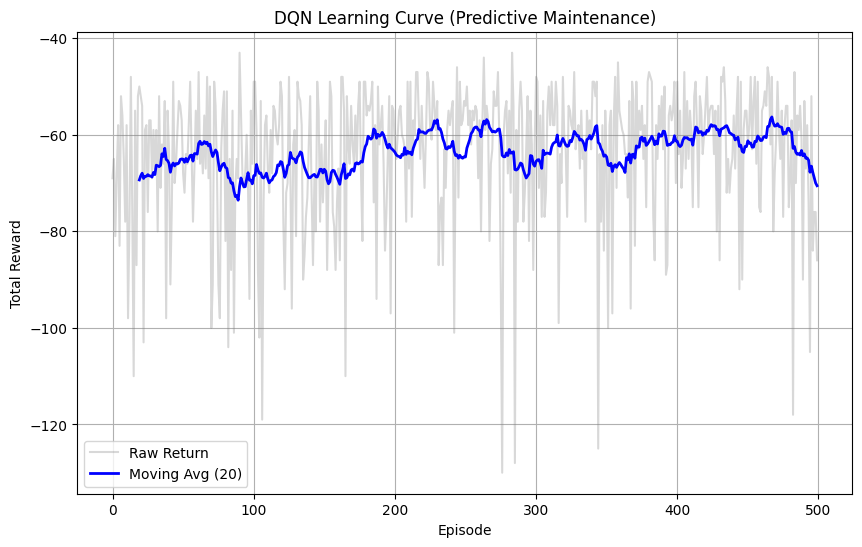


[Performance Comparison...]
Random   : Reward=-68.5, Failures=50
Heuristic: Reward=-41.6, Failures=50
DQN (RL) : Reward=-42.0, Failures=50


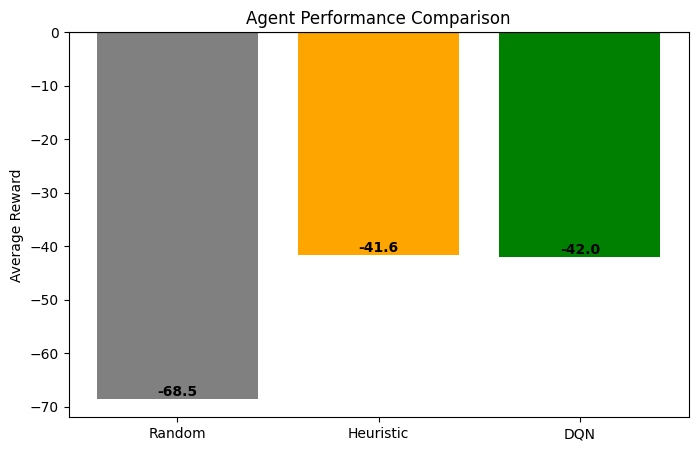

In [3]:
if __name__ == "__main__":
    # 1. 학습 진행
    agent, returns = train_dqn(
        num_episodes=500,        # 에피소드 수 증가 (수렴 확인용)
        max_steps_per_episode=200,
        target_update_interval=500,
        batch_size=64,
        render=False,
    )

    # 2. 학습 곡선 그리기
    plot_learning_curve(returns)

    # 3. 베이스라인 비교 평가 (보고서용)
    test_env = Ai4iMaintenanceEnv(max_steps=200) # 테스트용 환경 별도 생성
    compare_agents(test_env, agent)

* 태스크 개요:
현재 DQN 에이전트는 지속적으로 음수 평균 리턴을 보이고 있음

* 매개변수 조정
: pm_cost (예방 정비 비용): 5 -> 2
: fail_cost (고장 비용): 50
: prod_reward (스텝당 생산 보상): 1 -> 5

* DQN 하이퍼파라미터 튜닝
: 300 에피소드 동안의 현재 훈련 결과는 평균 리턴이 여전히 약 -60에서 -70 사이이며, eps_decay_steps=50_000은 300 에피소드 동안 엡실론이 매우 느리게 감소하여 제한된 지향적 탐색


Starting training with: pm_cost=2.0, fail_cost=50.0, prod_reward=5.0, lr=0.0005, eps_decay_steps=100000, num_episodes=1000
[Episode    1] Return =   -39.00 | Avg(20) =   -39.00 | Buffer =      5
[Episode    2] Return =   -49.00 | Avg(20) =   -44.00 | Buffer =      8
[Episode    3] Return =   -51.00 | Avg(20) =   -46.33 | Buffer =     19
[Episode    4] Return =   -41.00 | Avg(20) =   -45.00 | Buffer =     25
[Episode    5] Return =   -44.00 | Avg(20) =   -44.80 | Buffer =     29
[Episode    6] Return =   -19.00 | Avg(20) =   -40.50 | Buffer =     38
[Episode    7] Return =   -37.00 | Avg(20) =   -40.00 | Buffer =     42
[Episode    8] Return =   -55.00 | Avg(20) =   -41.88 | Buffer =     48
[Episode    9] Return =   -56.00 | Avg(20) =   -43.44 | Buffer =     51
[Episode   10] Return =   -45.00 | Avg(20) =   -43.60 | Buffer =     59
[Episode   11] Return =   -51.00 | Avg(20) =   -44.27 | Buffer =     63
[Episode   12] Return =    -7.00 | Avg(20) =   -41.17 | Buffer =     87
[Episode   13

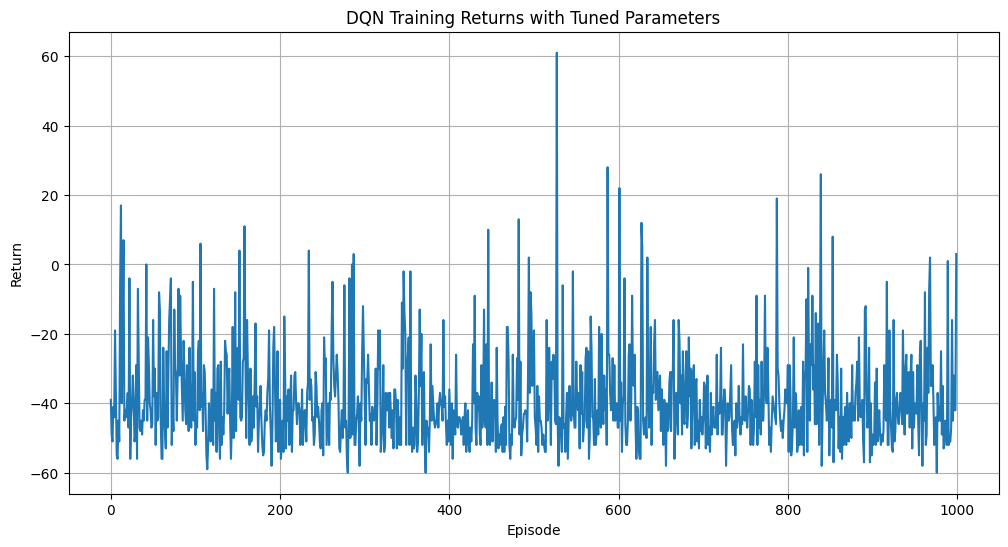

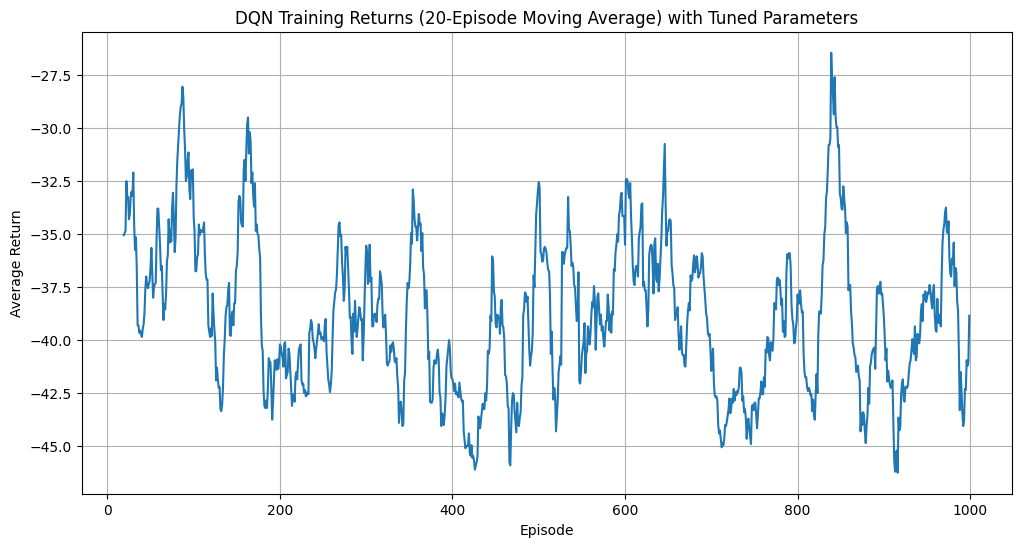

In [5]:
import matplotlib.pyplot as plt

def train_dqn_with_params(
    num_episodes: int = 500,
    max_steps_per_episode: int = 200,
    target_update_interval: int = 1000,
    batch_size: int = 64,
    render: bool = False,
    # New environment parameters
    pm_cost: float = 5.0,
    fail_cost: float = 50.0,
    prod_reward: float = 1.0,
    # New agent hyperparameters
    lr: float = 1e-3,
    gamma: float = 0.99,
    eps_decay_steps: int = 50_000,
):
    # Initialize environment with new cost/reward parameters
    env = Ai4iMaintenanceEnv(
        pm_cost=pm_cost,
        fail_cost=fail_cost,
        prod_reward=prod_reward,
        max_steps=max_steps_per_episode
    )
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    # Initialize agent with new hyperparameters
    agent = DQNAgent(
        state_dim,
        action_dim,
        lr=lr,
        gamma=gamma,
        eps_decay_steps=eps_decay_steps,
    )

    total_steps = 0
    episode_returns = []

    print(f"Starting training with: "
          f"pm_cost={pm_cost}, fail_cost={fail_cost}, prod_reward={prod_reward}, "
          f"lr={lr}, eps_decay_steps={eps_decay_steps}, num_episodes={num_episodes}")

    for episode in range(1, num_episodes + 1):
        state = env.reset()
        done = False
        ep_return = 0.0

        while not done:
            if render and (episode % 100 == 0):
                env.render()

            action = agent.select_action(state)
            next_state, reward, done, info = env.step(action)

            agent.buffer.push(state, action, reward, next_state, done)
            _ = agent.update(batch_size=batch_size) # We don't use loss in this loop

            state = next_state
            ep_return += reward
            total_steps += 1

            if total_steps % target_update_interval == 0:
                agent.update_target()

        episode_returns.append(ep_return)
        avg_return = np.mean(episode_returns[-20:])

        print(
            f"[Episode {episode:4d}] "
            f"Return = {ep_return:8.2f} | "
            f"Avg(20) = {avg_return:8.2f} | "
            f"Buffer = {len(agent.buffer):6d}"
        )

    # 학습 후 모델 저장
    os.makedirs("checkpoints", exist_ok=True)
    model_path = os.path.join("checkpoints", "dqn_ai4i_tuned.pt")
    torch.save(agent.q_net.state_dict(), model_path)
    print(f"Model saved to: {model_path}")

    return agent, episode_returns


# 재학습 실행
tuned_agent, tuned_returns = train_dqn_with_params(
    num_episodes=1000,                       # Increased episodes
    max_steps_per_episode=200,
    target_update_interval=1000,
    batch_size=64,
    render=False,
    pm_cost=2.0,                             # Adjusted environment parameter
    fail_cost=50.0,                          # Keep fail_cost high
    prod_reward=5.0,                         # Adjusted environment parameter
    lr=5e-4,                                 # Adjusted agent hyperparameter
    eps_decay_steps=100_000,                 # Adjusted agent hyperparameter
)

# 학습 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(tuned_returns)
plt.title('DQN Training Returns with Tuned Parameters')
plt.xlabel('Episode')
plt.ylabel('Return')
plt.grid(True)
plt.show()

# 추가적으로 20-episode 이동 평균도 같이 시각화
plt.figure(figsize=(12, 6))
smoothed_returns = pd.Series(tuned_returns).rolling(window=20).mean()
plt.plot(smoothed_returns)
plt.title('DQN Training Returns (20-Episode Moving Average) with Tuned Parameters')
plt.xlabel('Episode')
plt.ylabel('Average Return')
plt.grid(True)
plt.show()


[Performance Comparison...]
Random   : Reward=-37.0, Failures=50
Heuristic: Reward=-7.8, Failures=50
DQN (RL) : Reward=-10.1, Failures=50


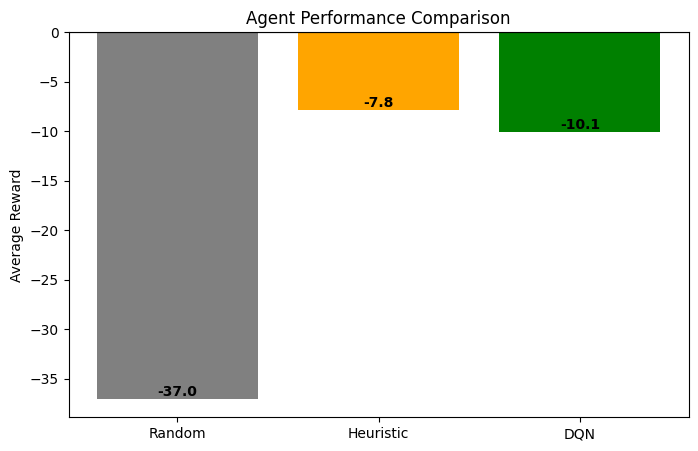

In [7]:
test_env = Ai4iMaintenanceEnv(
    max_steps=200,
    pm_cost=2.0,
    fail_cost=50.0,
    prod_reward=5.0
) # Initialize test_env with tuned parameters
compare_agents(test_env, tuned_agent)